# Implement a custom Autoencoder with Koopman layer

## Version Control

To Do:
1) Account for trailing batch - Make robust (fixed issue by reshaping input data)
2) Get Koopman operator, K
3) Preprocess Data
4) Make sure sim data is different for different ground parameters
5) Use static Koopman AE to train and get Koopman

## Setup

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
import  numpy as np
import pandas as pd
import time
from datetime import datetime

In [2]:
plt.rcParams['figure.figsize'] = [9, 6]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
#from google.colab import drive
#drive.mount('/gdrive')

Comment out if don't need

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Data

**Dyanmics of the Simple Pendulum**


![dynamics](\images\dynamics.PNG)


$\lambda = -1$
$\mu = -0.05$

In [5]:
discrete_train = pd.read_csv('data/DiscreteSpectrumExample_train1_x.csv', sep=',', header=None).values
discrete_test =pd.read_csv('data/DiscreteSpectrumExample_test_x.csv', sep=',', header=None).values
discrete_val = pd.read_csv('data/DiscreteSpectrumExample_val_x.csv', sep=',', header=None).values

In [6]:
trajLength = int(2^6) #length of each trajectory in the dataset
numTraj = int(2^10) #total number of trajectories in the dataset

batch_size = int(512)
numTraj_batch = int(batch_size/trajLength)

num_batches = int(batch_size/trajLength)
input_dim = 2

In [7]:
# Normalize the data
min_val = tf.reduce_min(discrete_train)
max_val = tf.reduce_max(discrete_train)

discrete_train = (discrete_train - min_val) / (max_val - min_val)
discrete_test = (discrete_test - min_val) / (max_val - min_val)

train_data = tf.cast(discrete_train, tf.float32)
test_data = tf.cast(discrete_test, tf.float32)

## Preprocess data

In [8]:
x_train = train_data
y_train = train_data

tf.shape(x_train)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([65536,     2])>

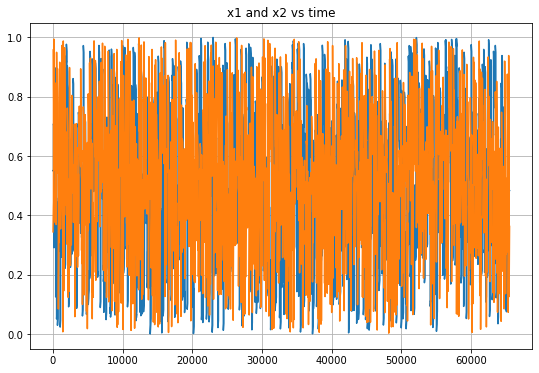

In [9]:
trail = train_data[trajLength*100:trajLength*110,:]
plt.grid()
plt.plot(x_train) #51 samples for each trajectory
plt.title("x1 and x2 vs time")
plt.show()

# Custom Model definition

## Encoder

In [10]:
class EncoderLayer(keras.layers.Layer):
    """
    Custom class to create a linear layer
    
    Parameters
    ----------
    units: number of units in the layer 
        units are assigned to the layer at the time of initialization
    
    input_shape: shape of the input (output from previous layer)
        input_shape is used to build the weight matrix at the time of call
        
    Return
    ----------
    W.T * x + b: tensor
        linear combination of weights times input + bias for the layer
    """
    
    def __init__(self, units=32, name=None, act='None'):
        super(EncoderLayer, self).__init__(name=name)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            name = 'weight',
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            name = 'bias',
            shape=(self.units,), initializer="zeros", trainable=True
        )
        #print("Encoder Layer, weight dimension:",tf.shape(self.w))

    def call(self, inputs):
        #print("Encoder Layer, output dimension:",tf.shape(tf.matmul(inputs, self.w) + self.b))
        return tf.matmul(inputs, self.w) + self.b

In [11]:
class EncoderModel(keras.Model):
    """
    Custom Model to create an encoder with one input
    
    Parameters
    ----------
    input: tensor 
        x - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    z: tensor
        Latent variables of x in the lifted space
    """
    
    def __init__(self, name=None, act='None'):
        super(EncoderModel, self).__init__(name=name)
        self.enc1 = EncoderLayer(32)
        self.enc2 = EncoderLayer(64)
        self.enc3 = EncoderLayer(128)

    def call(self, input):
        x = input
        x = self.enc1(x)
        x = tf.nn.elu(x)
        x = self.enc2(x)
        x = tf.nn.elu(x)

        # Encoder output layer
        z = self.enc3(x)
        z = tf.nn.elu(z)
        return z

enc_model = EncoderModel()

## Koopman

In [12]:
class KoopmanLayer(keras.layers.Layer):
    """
    Custom class to calculate the Koopman operator K on latent variables
    Adds a linear loss as mse(Z2-Z2_tilde)
    
    Parameters
    ----------
    Z: tensor 
        inputs are the latent variabes (output from encoder)
        input dimension is (m, 128)
        m is the number of time snapshots for each input dimension of X
        128 is the number of latent varibales (observables)

    Return
    ----------
    Z: tensor
        return the original input Z 

    Z2_tilde: tensor
        return the prediction by linearity from K (z2_tilde = K^m * z(1,:))
    """

    def __init__(self, trajLength, numTraj):
        super(KoopmanLayer, self).__init__()
        self.trajLength = trajLength
        self.numTraj = numTraj

    def build(self, Z):
        # Initialize K as a weight
            self.K =  self.add_weight(
                name = 'Koopman_weight',
                shape=(Z[-1], Z[-1]),
                initializer="random_normal",
                trainable=True,
            )

    def timeShift(self,Z,latent_dim):
        '''
        Shifts trajectories one time step
        Parameters:
        -----------
            Z: tensor
                Batch data of latent variables (in the lifted space)
                
            latent_dim: tensor shape
                Dimension of the lifted space (columns of Z)
        '''
        Z1 = []
        z1 = []
        Z2 = []

        for i in range(self.numTraj):
            Z1.append(Z[i*self.trajLength:(i+1)*self.trajLength-1,:])
            Z2.append(Z[i*self.trajLength+1:(i+1)*self.trajLength,:])
            z1.append(Z[i*self.trajLength,:])
        return tf.reshape(Z1, [-1, latent_dim]), tf.reshape(Z2, [-1, latent_dim]), tf.reshape(z1, [-1, latent_dim])       

    def call(self, Z):
        latent_dim = tf.shape(Z)[1]
        shift_len = (self.trajLength-1)*self.numTraj # length of rows for forward time shifted Z
        Z1, Z2, z1 = self.timeShift(Z,latent_dim)

        # Find Z2_tilde
        Z2_tilde = tf.zeros([shift_len, latent_dim], dtype=tf.float32)
        for traj in range(self.numTraj): # loop over numnber of traj
            for m in range(self.trajLength-1): #loop over snapshots in each traj
                 indices = tf.constant([[traj*self.trajLength]])
                 if m == 0: 
                     updates = [tf.linalg.matvec(self.K, z1[0,:])]
                     tf.tensor_scatter_nd_update(Z2_tilde, indices, updates)
                 else:
                    updates = [tf.linalg.matvec(tf.matmul(self.K,self.K), z1[traj,:])]
                    tf.tensor_scatter_nd_update(Z2_tilde, indices, updates)
                    
        # Find linear loss
        Linear_loss = tf.reduce_mean(tf.square(Z2-Z2_tilde))
        self.add_loss(Linear_loss)
        
        # prints for debugging dimensions
        #print("Koopman layer, K",tf.shape(K))
        #print("Koopman layer, m",tf.shape(m))
        #print("Koopman layer, Z",tf.shape(Z))
        #print("Koopman layer, z1",tf.shape(z1))
        #print("Koopman layer, Z2 ",tf.shape(Z2))
        #print("Koopman layer, Z2_tilde",tf.shape(Z2_tilde))

        return Z, Z2_tilde

In [13]:
class Koopman_Model(keras.Model):
    """
    Custom Model to create an encoder with koopman layer
    
    Parameters
    ----------
    input: tensor 
        z - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    z: tensor
        Latent variables of x in the lifted space

    z2_tilde: tensor
        Latent variables of prediction obtained by linearity from K (z2_tilde = K^m * z(1,:))
        
    K: tensor
        Koopman operator in the lifted space
    """
    
    def __init__(self, trajLength, numTraj , name=None, act='None'):
        super(Koopman_Model, self).__init__(name=name)
        self.koopman = KoopmanLayer(trajLength,numTraj)


    def call(self, input):
        z = input
        z, z2_tilde = self.koopman(z)
        return z, z2_tilde


koop_model = Koopman_Model(trajLength,numTraj_batch)

## Decoder

In [14]:
class DecoderLayer(keras.layers.Layer):
    """
    Custom class to create a decoder layer with two inputs
    
    Parameters
    ----------
    units: number of units in the layer 
        units are assigned to the layer at the time of initialization
    
    input_shape: shape of the input (output from previous layer)
        input_shape is used to build the weight matrix at the time of call
        
    Return
    ----------
    W.T * input1 + b: tensor
        linear combination of weights times input1 + bias for the layer
        
    W.T * input2 + b: tensor
        linear combination of weights times input2 + bias for the layer
    """

    def __init__(self, units=32, name=None):
        super(DecoderLayer, self).__init__(name=name)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            name = 'weight',
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            name = 'bias',
            shape=(self.units,), initializer="zeros", trainable=True
        )
        #print("Decoder Layer, weight dimension:",tf.shape(self.w))

    def call(self, input1, input2):
        #print("Decoder Layer, output dimension:",tf.shape(tf.matmul(inputs, self.w) + self.b))
        return tf.matmul(input1, self.w) + self.b, tf.matmul(input2, self.w) + self.b

In [15]:
class DecoderModel(keras.Model):
    """
    Custom Model to create a decoder with two inputs
    
    Parameters
    ----------
    input 1: tensor 
        z - the lifted output of the koopman layer (encoder output)
    
    input 2: tensor 
        z2_tilde - obtained by linearity from K (z2_tilde = K^m * z(1,:))
        
    Return
    ----------
    x_hat: tensor
        Reconstuction of the orignal state inputs x (label values are x)
    
    x2_hat: tensor
        Predcition of the original state inputs x (label values are forward time shifted x)
    """
    
    def __init__(self, name=None, act='None'):
        super(DecoderModel, self).__init__(name=name)
        self.dec1 = DecoderLayer(64)
        self.dec2 = DecoderLayer(32)
        self.outputLayer = DecoderLayer(2)

    def call(self, input1, input2):
        z = input1
        z2_tilde = input2

        z, z2_tilde = self.dec1(z, z2_tilde)
        z = tf.nn.elu(z)
        z2_tilde = tf.nn.elu(z2_tilde)

        z, z2_tilde = self.dec2(z, z2_tilde)
        z = tf.nn.elu(z)
        z2_tilde = tf.nn.elu(z2_tilde)

        # Decoder output layer
        x_hat, x2_hat = self.outputLayer(z, z2_tilde)
        x_hat = tf.nn.elu(x_hat)
        x2_hat = tf.nn.elu(x2_hat)

        return x_hat, x2_hat

dec_model = DecoderModel(trajLength,numTraj_batch)

## Koopman Autoencoder

In [16]:
class Koopman_AE(keras.Model):
    """
    Custom Model to create a Koopman Autoencoder
    
    Parameters
    ----------
    input: tensor 
        x - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    x_hat: tensor
        Reconstuction of the orignal state inputs x (label values are x)
    
    x2_hat: tensor
        Predcition of the original state inputs x (label values are forward time shifted x)
    """
    
    def __init__(self, trajLength, numTraj , name=None, act='None'):
        super(Koopman_AE, self).__init__(name=name)
        self.enc = EncoderModel()
        self.koopman = Koopman_Model(trajLength, numTraj)
        self.dec = DecoderModel()

    def call(self, input):
        x = input
        z = self.enc(x)
        z, z2_tilde = self.koopman(z)
        x_hat, x2_hat = self.dec(z, z2_tilde)
        return x_hat, x2_hat
        
koop_ae = Koopman_AE(trajLength, numTraj_batch)

In [17]:
print("Input",tf.shape(x_train))
x_hat, x2_hat = koop_ae(x_train)
print("output Layer x_hat",tf.shape(x_hat))
print("output Layer x2_hat",tf.shape(x2_hat))
print("input for predictions",tf.shape(x_train[1:,:]))

Input tf.Tensor([65536     2], shape=(2,), dtype=int32)
output Layer x_hat tf.Tensor([65536     2], shape=(2,), dtype=int32)
output Layer x2_hat tf.Tensor([384   2], shape=(2,), dtype=int32)
input for predictions tf.Tensor([65535     2], shape=(2,), dtype=int32)


In [18]:
koop_ae.summary()

Model: "koopman_ae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_model_1 (EncoderMode multiple                  10528     
_________________________________________________________________
koopman__model_1 (Koopman_Mo multiple                  16384     
_________________________________________________________________
decoder_model (DecoderModel) multiple                  10402     
Total params: 37,314
Trainable params: 37,314
Non-trainable params: 0
_________________________________________________________________


# Custom Training Loop

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_data))
train_dataset = train_dataset.batch(batch_size)

In [20]:
def reconstruction_loss(y_true, y_pred):
    """Calculates the Mean Squared Error between y_pred and y_true vectors"""
    return tf.reduce_mean(tf.abs(y_true-y_pred)) #avg loss for each batch since reduce_mean is already an avg

def prediction_loss(x, x2_hat, numTraj_batch, trajLength):
        """Calculates prediction loss from x2 (time shifted x) to output x2_hat"""
        x2 = []
        for i in range(numTraj_batch):
            x2.append(x[i*trajLength+1:(i+1)*trajLength,:])
        x2 = tf.reshape(x2, [-1, x_train.shape[-1]])
        return tf.reduce_mean(tf.abs(x2-x2_hat)) #avg loss for each batch since reduce_mean is already an av

def total_loss(model, recon_loss, predict_loss):
    """Calculates total loss as sum of recon_loss + predict_loss + Koopman_loss"""
    return recon_loss + predict_loss + sum(model.losses)

In [21]:
koop_ae = Koopman_AE(trajLength, numTraj_batch)
variables = koop_ae.trainable_variables
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
epochs = 1

total_loss_list = [] # total loss for each epoch
for epoch in range(epochs):
  batch_tot_loss_list = [] # ttal loss for each batch 
  #reconstruction_loss_batch = []
  #prediction_loss_batch = []
  
  print("\nStart of epoch %d" % (epoch,))
  start_time = time.time()

  # Iterate over the batches of the dataset.
  for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      batch_length =  len(x_batch_train) #num elements in each batch
      reconstruction, predictions = koop_ae(x_batch_train)
      
      # avg loss for each batch
      recon_loss =  reconstruction_loss(y_batch_train, reconstruction)
      predict_loss =  prediction_loss(y_batch_train, predictions, numTraj_batch, trajLength)

      # total avg loss for each batch
      batch_tot_loss = total_loss(koop_ae,recon_loss, predict_loss)
      batch_tot_loss_list.append(batch_tot_loss)
      
    grads = tape.gradient(batch_tot_loss, variables)
    #grads = tape.gradient(batch_tot_loss, variables, unconnected_gradients=tf.UnconnectedGradients.ZERO)
    optimizer.apply_gradients(zip(grads, variables))
    
    # Log every 100 batches.
    if step % 100 == 0:
        print(
            "Training loss (for one batch) at step %d: %.4f"
            % (step, float(batch_tot_loss))
        )
        print("Seen so far: %s samples" % ((step + 1) * batch_size))
  
  # outside batch loop
  total_loss_avg = np.sum(batch_tot_loss_list)/num_batches
  total_loss_list.append(total_loss_avg)

  print(
          "Average trainig loss at epoch %d: %.4f"
          % (epoch, float(total_loss_avg))
      )
  print("Time taken: %.2fs" % (time.time() - start_time))



Start of epoch 0
Training loss (for one batch) at step 0: 1.2514
Seen so far: 512 samples
Training loss (for one batch) at step 100: 1.2478
Seen so far: 51712 samples
Average trainig loss at epoch 0: 1.1407
Time taken: 48.46s


# Plots

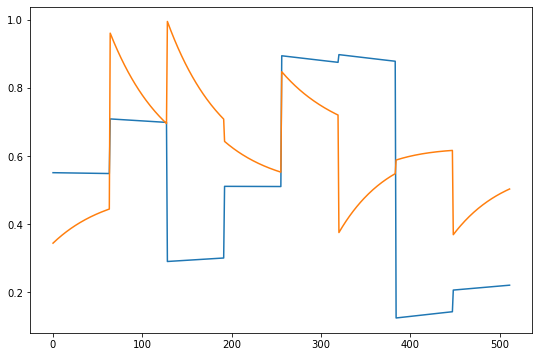

In [22]:
input = x_train[0:batch_size]
plt.plot(input)

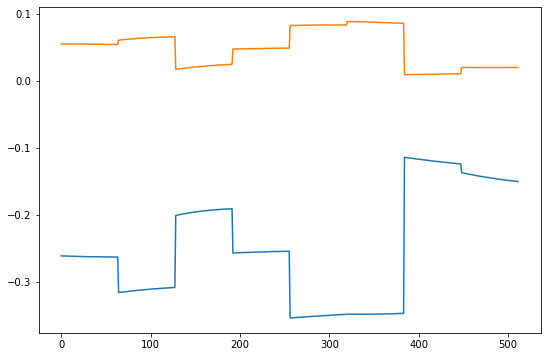

In [23]:
out1, out2 = koop_ae(input)
plt.plot(out1)

# Save the Model

In [24]:
koop_ae.save('checkpoints/Static_koopman1')

INFO:tensorflow:Assets written to: checkpoints/Static_koopman1\assets


# Load the Model

In [25]:
new_model = tf.keras.models.load_model('checkpoints/Static_koopman1', compile=False)


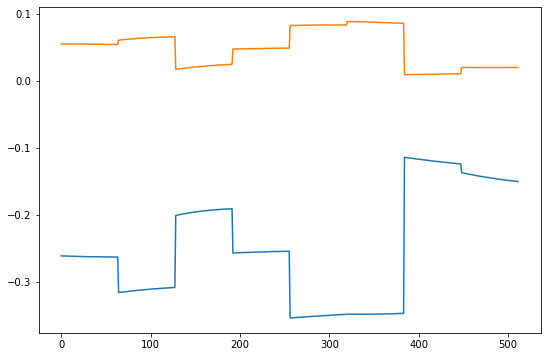

In [26]:
new_out1, new_out2 = new_model(input)
plt.plot(new_out1)

In [27]:
new_model.summary()

Model: "koopman_ae_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_model_2 (EncoderMode multiple                  10528     
_________________________________________________________________
koopman__model_2 (Koopman_Mo multiple                  16384     
_________________________________________________________________
decoder_model_1 (DecoderMode multiple                  10402     
Total params: 37,314
Trainable params: 37,314
Non-trainable params: 0
_________________________________________________________________


In [38]:
Z = new_model.enc(x_train)
K = new_model.koopman.get_weights()
K = np.squeeze(K)